# Anomaly detection using FBProphet

# 1- Importing key Modules

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False


In [7]:
from fbprophet import Prophet

# 2- Reading data

In [37]:
df = pd.read_csv('nyc_taxi.csv')
df.shape

(10320, 2)

In [31]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [32]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


In [33]:
df = df.set_index('timestamp').resample("H").mean() # H means aggregate on hourly basis

In [34]:
df.shape

(5160, 1)

In [35]:
df.head()

,value
timestamp,
2014-07-01 00:00:00,9485.5
2014-07-01 01:00:00,5433.0
2014-07-01 02:00:00,3346.5
2014-07-01 03:00:00,2216.5
2014-07-01 04:00:00,2189.5


In [36]:
df.tail()

,value
timestamp,
2015-01-31 19:00:00,28288.5
2015-01-31 20:00:00,24138.0
2015-01-31 21:00:00,24194.5
2015-01-31 22:00:00,26515.0
2015-01-31 23:00:00,26439.5


In [6]:
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi Demand')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                     dict(count=1, label='1y', step='year', stepmode='backward'),
                     dict(count=2, label='3y', step='year', stepmode='backward'),
                     dict(count=3, label='5y', step='year', stepmode='backward'),
                     dict(step='all')
        ])
    )
)
fig.show()

In [8]:
taxi_df = df.reset_index()[['timestamp', 'value']].rename({'timestamp':'ds', 
                                                           'value':'y'}, 
                                                          axis='columns')

In [9]:
taxi_df.head()

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


### Splitting train-test data

In [10]:
train = taxi_df[(taxi_df['ds']>='2014-07-01')&(taxi_df['ds']<='2015-01-27')]
test = taxi_df[(taxi_df['ds']>'2015-01-27')]

In [11]:
print(train.shape)
print(test.shape)

(5041, 2)
(119, 2)


In [12]:
model = Prophet(changepoint_range=0.95) # confidence interval of output

In [13]:
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [14]:
future = model.make_future_dataframe(periods=119, freq='H')

In [15]:
future.head()

,ds
0,2014-07-01 00:00:00
1,2014-07-01 01:00:00
2,2014-07-01 02:00:00
3,2014-07-01 03:00:00
4,2014-07-01 04:00:00


In [16]:
future.tail()

,ds
5155,2015-01-31 19:00:00
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00
5159,2015-01-31 23:00:00


### Finding confidence interval

In [17]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5155,2015-01-31 19:00:00,23778.529213,19006.113054,28607.239931
5156,2015-01-31 20:00:00,24342.584334,19531.504394,29105.014623
5157,2015-01-31 21:00:00,23219.297735,18285.838812,28251.835765
5158,2015-01-31 22:00:00,21027.355314,15818.862705,25641.957778
5159,2015-01-31 23:00:00,18500.216845,13948.711055,23492.539651


In [18]:
results = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower', 'yhat_upper']]],
                    axis=1)

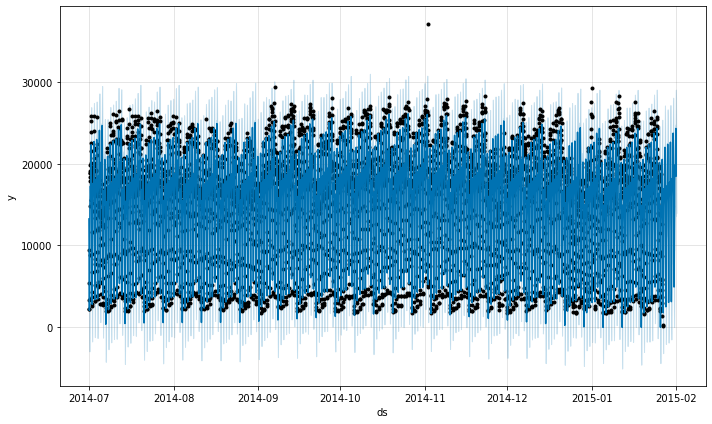

In [19]:
fig1 = model.plot(forecast)

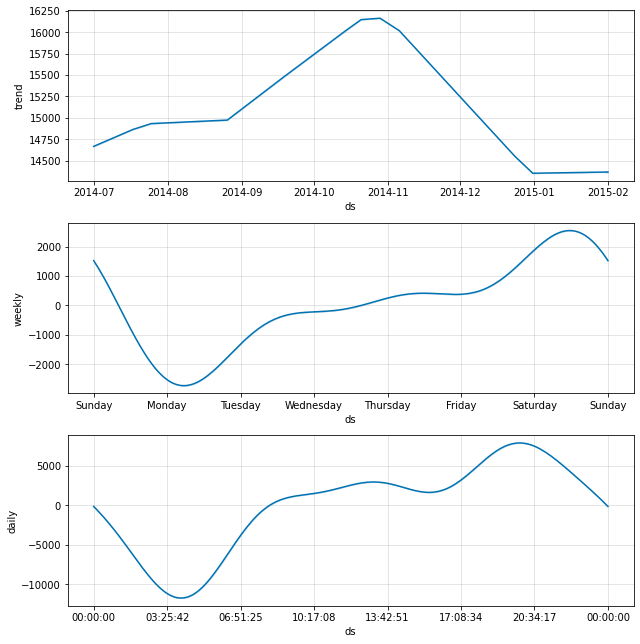

In [20]:
comp = model.plot_components(forecast)

In [21]:
results.head()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8480.787852,18381.798183
2014-07-01 01:00:00,5433.0,10232.486172,5606.390945,14787.608595
2014-07-01 02:00:00,3346.5,6669.099458,2017.893224,11477.572449
2014-07-01 03:00:00,2216.5,3448.054270,-1429.540245,8499.352135
2014-07-01 04:00:00,2189.5,2017.409931,-3015.897542,6692.735798


### Error calculation

In [22]:
results['error'] = results['y'] - results['yhat']

### Uncertainity 

In [23]:
results['uncertainity'] = results['yhat_upper'] - results['yhat_lower']

In [24]:
results.head()

,y,yhat,yhat_lower,yhat_upper,error,uncertainity
ds,,,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8480.787852,18381.798183,-3755.232792,9901.010330
2014-07-01 01:00:00,5433.0,10232.486172,5606.390945,14787.608595,-4799.486172,9181.217650
2014-07-01 02:00:00,3346.5,6669.099458,2017.893224,11477.572449,-3322.599458,9459.679225
2014-07-01 03:00:00,2216.5,3448.054270,-1429.540245,8499.352135,-1231.554270,9928.892380
2014-07-01 04:00:00,2189.5,2017.409931,-3015.897542,6692.735798,172.090069,9708.633340


### Threshold for anomaly

In [25]:
results[results['error'].abs()>1.5*results['uncertainity']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainity
ds,,,,,,
2014-11-02 01:00:00,37204.5,14218.892870,9284.322343,19099.503534,22985.607130,9815.181191
2015-01-01 01:00:00,29292.0,11405.545567,6841.079060,16286.999029,17886.454433,9445.919969
2015-01-01 02:00:00,25753.5,7770.054639,2985.112293,12497.371367,17983.445361,9512.259074
2015-01-01 03:00:00,22067.0,4478.895177,-411.836503,9236.425261,17588.104823,9648.261764
2015-01-26 19:00:00,4565.5,19771.308307,14837.810999,24974.581933,-15205.808307,10136.770933
2015-01-26 20:00:00,3630.5,20546.581743,16165.681735,25411.594792,-16916.081743,9245.913057
2015-01-26 21:00:00,2907.0,19647.710004,14793.258501,24373.103555,-16740.710004,9579.845055
2015-01-26 22:00:00,1324.5,17691.969234,13243.557477,22154.712839,-16367.469234,8911.155361
2015-01-26 23:00:00,243.0,15411.348672,10510.753799,20555.128404,-15168.348672,10044.374606


In [26]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error'])>1.5*x['uncertainity']) else 'No',axis=1)

In [27]:
results.head()

,y,yhat,yhat_lower,yhat_upper,error,uncertainity,anomaly
ds,,,,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8480.787852,18381.798183,-3755.232792,9901.010330,No
2014-07-01 01:00:00,5433.0,10232.486172,5606.390945,14787.608595,-4799.486172,9181.217650,No
2014-07-01 02:00:00,3346.5,6669.099458,2017.893224,11477.572449,-3322.599458,9459.679225,No
2014-07-01 03:00:00,2216.5,3448.054270,-1429.540245,8499.352135,-1231.554270,9928.892380,No
2014-07-01 04:00:00,2189.5,2017.409931,-3015.897542,6692.735798,172.090069,9708.633340,No


In [28]:
fig = px.scatter(results.reset_index(), x='ds', y='y', 
                 color='anomaly',title='NYC Taxi Demand')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                     dict(count=1, label='1y', step='year', stepmode='backward'),
                     dict(count=2, label='3y', step='year', stepmode='backward'),
                     dict(count=3, label='5y', step='year', stepmode='backward'),
                     dict(step='all')
        ])
    )
)
fig.show()

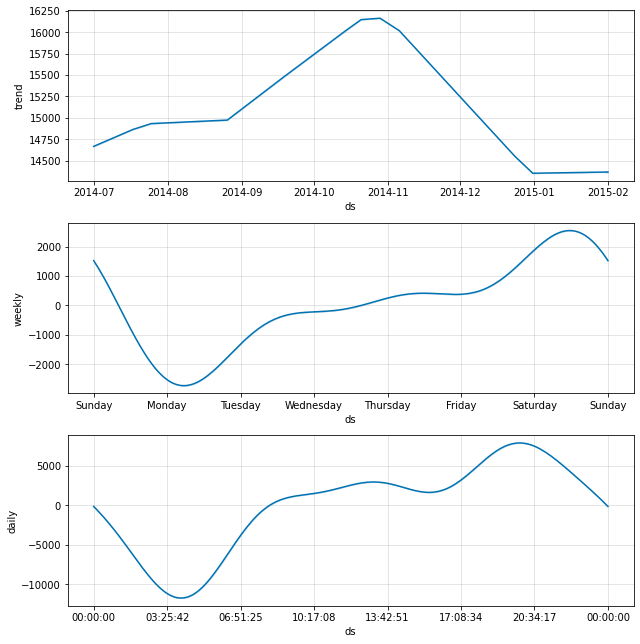

In [29]:
comp = model.plot_components(forecast)